# Model comparison to GO-SHIP Easy Ocean
This notebook shows a means of comparing MOM6 ocean model data to WOCE/GO-SHIP sections. These sections have been interpolated onto consistent lat-lon-pressure coordinates for ease of comparison with ocean model data. See [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on observational data and interpolation details.

In [2]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import gfdl_utils as gu
import glob
import cmocean
import gsw
import os
import re

## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [13]:
line = 'SR01'
time = '2010-2014'

## Read model data

In [14]:
pathDict = {'pp':'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp',
            'out':'av'}
pathDict['ppname']='ocean_annual_z_1x1deg'
pathDict['time']=time
pathDict['local']='annual_5yr'
pathDict['add']='ann'

In [15]:
dsm = gu.core.open_frompp(**pathDict)

In [16]:
rolllon = dsm['lon'].roll(lon=180)
newlon = rolllon.where(rolllon<180,-1*(360-rolllon))
dsm = dsm.roll(lon=180).assign_coords({'lon':newlon})

## Read GO-SHIP Easy Ocean data

In [17]:
rootdir = glob.glob('/work/gam/GO-SHIP/gridded/*/'+line)[0]
# See all possible iterations of this WOCE line
filenames = line.lower()+'_*.xyz'
path = '/'.join([rootdir,filenames])
# Get list of available years
years = []
for file in glob.glob(path):
    # Year will always be last number in filename
    years.append(int(re.findall(r'\d+', os.path.basename(file))[-1]))
years = np.array(years)
# Find year closest to model year
yearo = years[np.argmin(np.abs(dsm['time.year'].values-years))]
yearo

# Read in .xyz file
filename = line.lower()+'_'+str(yearo)+'.xyz'
path = '/'.join([rootdir,filename])
df = pd.read_csv(path,skiprows=[0,1],delim_whitespace=True,
                names=['Lat/Lon','pressure','temperature',
                      'practical_salinity','oxygen',
                      'conservative_temperature','absolute_salinity'],
                na_values=-999)

# Convert to xarray DataArray
dims = list(df.columns[0:2].values)
coords = {dims[0]:df[dims[0]].unique(),
          dims[1]:df[dims[1]].unique()}

dso = xr.Dataset(coords=coords)
for variable in df.columns[2:]:
    da = xr.DataArray(dims=dims,coords=coords,name=variable)
    data = np.reshape(df[variable].values,
                    newshape=da.shape)
    da.data = data
    dso[variable] = da
dso = dso.transpose()

# Retrieve missing lat/lon value
# (.xyz only give one horizontal dimension)
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)
# And assign appropriately
if len(dso_nc['latitude'])==1:
    dimx = 'longitude'
    dso=dso.rename({'Lat/Lon':dimx})
    dso['latitude']=dso_nc['latitude']
elif len(dso_nc['longitude'])==1:
    dimx = 'latitude'
    dso=dso.rename({'Lat/Lon':dimx})
    dso['longitude']=dso_nc['longitude']
    
# Change temperature and salinity names to match model
dso = dso.rename({'temperature':'thetao','practical_salinity':'so'})

## Interpolate model data to location of observations

In [18]:
dsmo = dsm.interp({'lat':dso['latitude'],'lon':dso['longitude'],'z_l':dso['pressure']}).squeeze()

## Plot

In [19]:
# Calculate sigma2 for referencing approximate neutral surfaces
dso['sigma2'] = gsw.sigma2(dso['absolute_salinity'],dso['conservative_temperature'])
dsmo['sigma2'] = gsw.sigma2(dsmo['so'],dso['thetao'])

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


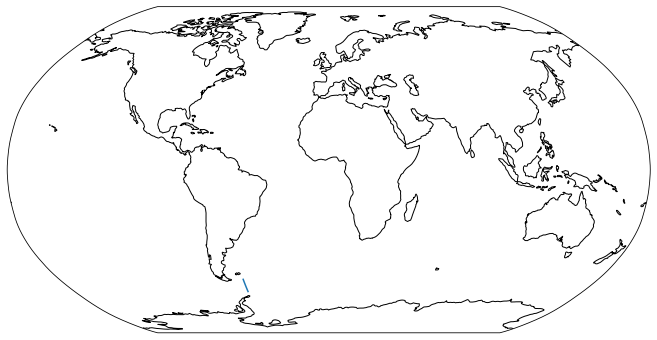

In [20]:
if dimx=='longitude':
    x=dso['longitude'].values
    y=dso['latitude']*xr.ones_like(dso['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso['longitude']*xr.ones_like(dso['latitude']).squeeze().values
    y=dso['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

In [21]:
def pcolormesh_splity(x,y,z,ax_above,ax_below,split,invert=True,cmap='viridis',title=None):
    im_above = ax_above.pcolormesh(x,y,z)
    im_below = ax_below.pcolormesh(x,y,z)
    if invert:
        ylim_above = [split,0]
        ylim_below = [np.max(y),split]
    else:
        ylim_above = [0,split]
        ylim_below = [split,np.max(y)]
    ax_above.set_ylim(ylim_above)
    ax_below.set_ylim(ylim_below)
    # ax_above.spines['bottom'].set_visible(False)
    # ax_below.spines['top'].set_visible(False)
    ax_above.xaxis.tick_top()
    ax_above.tick_params(labeltop=False)
    ax_below.xaxis.tick_bottom()
    plt.subplots_adjust(hspace=0.02)
    im_above.set_cmap(cmap)
    im_below.set_cmap(cmap)
    if title is not None:
        ax_below.annotate(title,xy=(0.02,0.1),xycoords='axes fraction',fontsize=16,bbox={'facecolor':'w'})
    
    return (im_above,im_below)

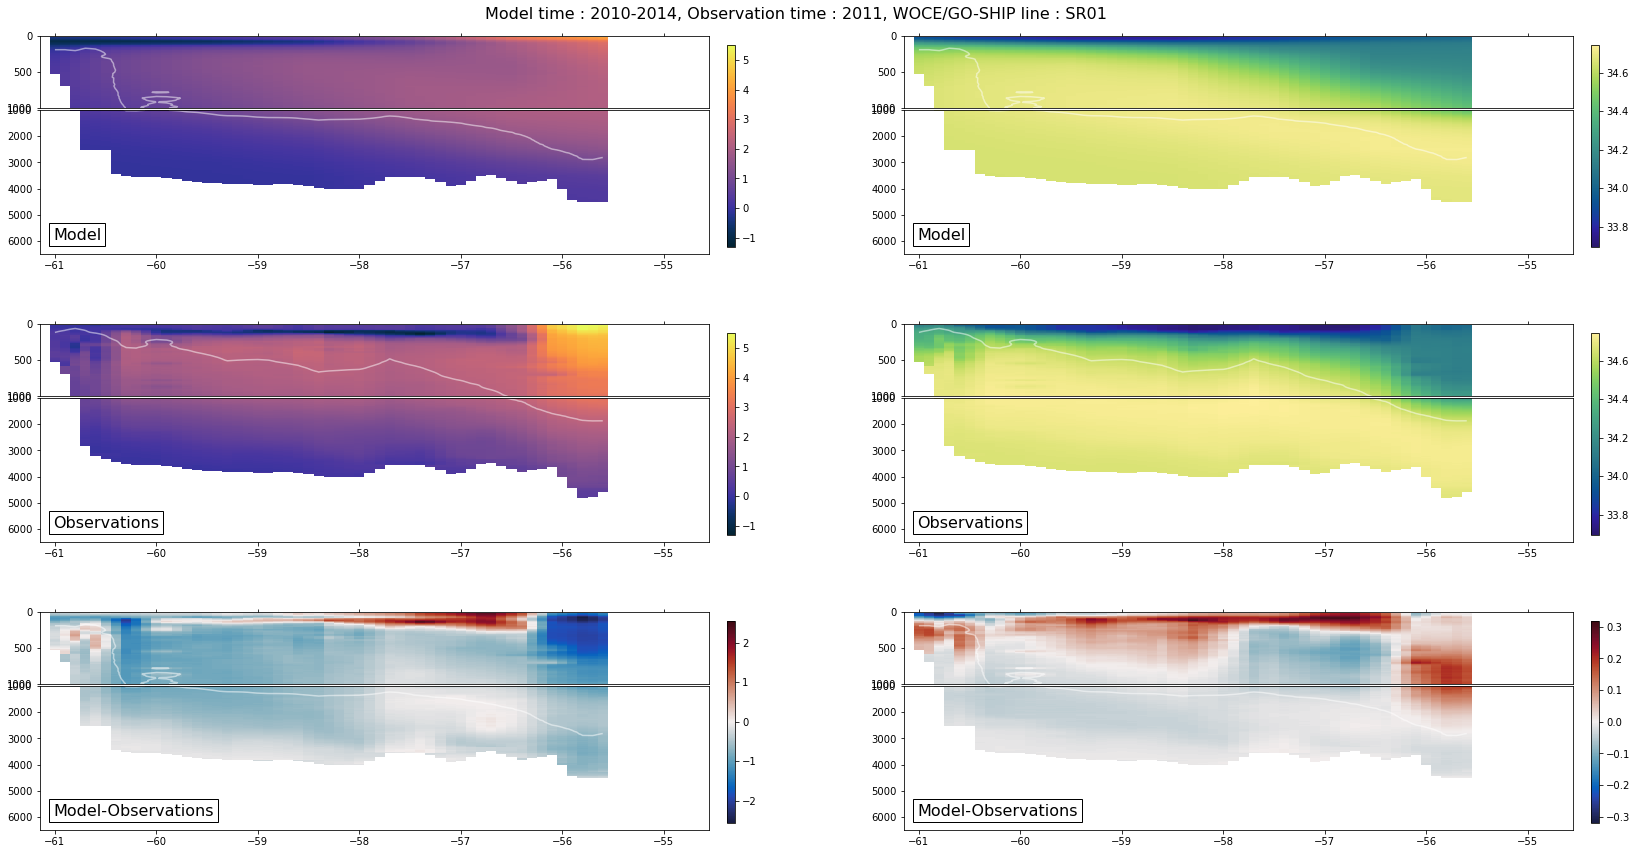

In [22]:
plot_kwargs = {'thetao':{'cmap':cmocean.cm.thermal},
               'so':{'cmap':cmocean.cm.haline}}
x = dso[dimx]
y = dso['pressure']

zclevs = np.linspace(30,38,8)

fig = plt.figure(figsize=(24,12))
fig.suptitle('Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line,
            fontsize=16,verticalalignment='baseline')

subfigs_all = fig.subfigures(nrows=3, ncols=2)
for v,variable in enumerate(['thetao','so']):
    subfigs = subfigs_all[:,v]
    
    zo = dso[variable]
    zm = dsmo[variable].where(np.isfinite(dso[variable]))
    cmap = plot_kwargs[variable]['cmap']
    clims = [np.min(zo),np.max(zo)]
    
    for i, subfig in enumerate(subfigs):
        if i==0:
            z = zm
            zc = dsmo['sigma2']
            title = 'Model'
        elif i==1:
            z = zo
            zc = dso['sigma2']
            title = 'Observations'
        elif i==2:
            z = zm-zo
            zc = dsmo['sigma2']
            title = 'Model-Observations'
            cmap = cmocean.cm.balance
            maxv = np.max(np.abs(z)).values
            clims = [-1*maxv,maxv]
        
        ax = subfig.subplots(nrows=2,ncols=1,sharex=True,gridspec_kw={"height_ratios":[1, 2]})
        im = pcolormesh_splity(x,y,z,ax[0],ax[1],split=1000,invert=True,cmap=cmap,title=title)
        im[0].set_clim(clims)
        im[1].set_clim(clims)
        
        ax[0].contour(x,y,zc,levels=zclevs,colors='w',alpha=0.5)
        ax[1].contour(x,y,zc,levels=zclevs,colors='w',alpha=0.5)
        
        
        cax = subfig.add_axes([0.92, 0.15, 0.01, 0.7])
        subfig.colorbar(im[0],cax=cax)